In [26]:
from __future__ import annotations
import re
from pathlib import Path
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as mtick



In [27]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [28]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [29]:
COLS = [
    "Description", "Code", "Number of jobs (thousand)",
    "Median", "Annual percentage change (Median)",
    "Mean", "Annual percentage change (Mean)",
    "10", "20", "25", "30", "40", "60", "70", "75", "80", "90"
]

In [30]:
CODE_RE = re.compile(r"^\d{1,4}$")  # codes like 1, 11, 111, 1111

def _pick_engine(path: Path) -> str | None:
    ext = path.suffix.lower()
    if ext == ".xlsx":
        return "openpyxl"
    elif ext == ".xls":
        return "xlrd"  # requires xlrd<2.0
    return None

In [31]:
def _extract_year(text: str) -> int | None:
    if not text:
        return None
    m = re.search(r"\b(20\d{2})\b", str(text))
    return int(m.group(1)) if m else None

In [32]:
def _year_from_file_or_a1(raw: pd.DataFrame, path: Path) -> int | None:
    # Try A1
    a1 = None
    if raw.shape[0] > 0 and raw.shape[1] > 0:
        a1 = str(raw.iloc[0, 0]) if pd.notna(raw.iloc[0, 0]) else ""
    y = _extract_year(a1)
    if y:
        return y
    # Fallback to filename
    return _extract_year(path.name)

In [33]:
def _is_data_row(row) -> bool:
    """
    A data row should have:
      - Description (col 0) present and not 'description'
      - Code (col 1) matching the code regex (pure digits, length 1–4)
    """
    desc = row[0]
    code = row[1]
    if pd.isna(desc) or pd.isna(code):
        return False
    if str(desc).strip().lower() == "description":
        return False
    return bool(CODE_RE.match(str(code).strip()))

In [34]:
def load_one_excel_skipheaders(path: str | Path, sheet_name: str = "All") -> pd.DataFrame:
    path = Path(path)
    engine = _pick_engine(path)
    # Read raw without headers; only A:Q (17 columns)
    raw = pd.read_excel(path, sheet_name=sheet_name, header=None, usecols="A:Q", engine=engine)

    # Find first data row
    start_idx = None
    for i in range(len(raw)):
        row = raw.iloc[i, :].tolist()
        if _is_data_row(row):
            start_idx = i
            break
    if start_idx is None:
        raise ValueError("Could not locate the first data row (no valid Code in column B).")

    # Find stop row where Description == 'Not Classified' (inclusive)
    stop_idx = None
    for i in range(start_idx, len(raw)):
        desc = raw.iat[i, 0]
        if pd.notna(desc) and str(desc).strip().lower() == "not classified":
            stop_idx = i
            break
    if stop_idx is None:
        # If not found, use the last non-empty row in Description
        last_non_empty = raw.iloc[start_idx:, 0].last_valid_index()
        stop_idx = int(last_non_empty) if last_non_empty is not None else len(raw) - 1

    # Slice and name columns
    block = raw.iloc[start_idx:stop_idx+1, :len(COLS)].copy()
    block.columns = COLS

    # Clean
    block["Description"] = block["Description"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    block["Code"] = block["Code"].astype(str).str.strip()

    # Coerce numeric columns where appropriate (ignore Description/Code)
    for c in COLS[2:]:
        if c in block.columns:
            block[c] = pd.to_numeric(block[c], errors="coerce")

    # Year
    year = _year_from_file_or_a1(raw, path)
    block["Year"] = year

    return block.reset_index(drop=True)

In [35]:
def load_directory_skipheaders(folder: str | Path) -> pd.DataFrame:
    folder = Path(folder)
    files = sorted([p for p in folder.iterdir() if p.suffix.lower() in {".xlsx", ".xls"}])
    if not files:
        raise FileNotFoundError(f"No .xlsx/.xls files found in {folder}")

    frames = []
    errors = []
    for p in files:
        try:
            frames.append(load_one_excel_skipheaders(p))
        except Exception as e:
            errors.append(f"[WARN] Skipping {p.name}: {e}")
    if errors:
        print("\n".join(errors))
    if not frames:
        raise RuntimeError("No files loaded successfully.")
    return pd.concat(frames, ignore_index=True)


In [36]:
df_all = load_directory_skipheaders("../data/item-18a")

In [37]:
df_all.head()

,Description,Code,Number of jobs (thousand),Median,Annual percentage change (Median),Mean,Annual percentage change (Mean),10,20,25,30,40,60,70,75,80,90,Year
0,"Managers, directors and senior officials",1,2081.0,37748.0,1.2,52602.0,0.6,14384.0,20999.0,23872.0,26486.0,31975.0,44815.0,54280.0,60531.0,67996.0,96830.0,2014
1,Corporate managers and directors,11,1748.0,40497.0,1.0,56094.0,-0.2,14540.0,22121.0,25250.0,28539.0,34438.0,48303.0,58399.0,64415.0,72997.0,101905.0,2014
2,Chief executives and senior officials,111,72.0,72366.0,-5.4,103389.0,-6.8,21519.0,36469.0,41815.0,48971.0,60013.0,90231.0,105664.0,119242.0,133133.0,NaN,2014
3,Chief executives and senior officials,1115,68.0,75496.0,-10.5,108407.0,-7.8,25989.0,40688.0,46793.0,53052.0,63359.0,93625.0,109353.0,122453.0,140216.0,NaN,2014
4,Elected officers and representatives,1116,NaN,NaN,NaN,20061.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


In [38]:
df_all["Year"].value_counts().sort_index()

Year
2014    494
2015    494
2016    494
2017    494
2018    494
2019    494
2020    494
2021    552
2022    552
2023    552
2024    552
Name: count, dtype: int64

In [39]:
df_all.columns.tolist()

['Description',
 'Code',
 'Number of jobs (thousand)',
 'Median',
 'Annual percentage change (Median)',
 'Mean',
 'Annual percentage change (Mean)',
 '10',
 '20',
 '25',
 '30',
 '40',
 '60',
 '70',
 '75',
 '80',
 '90',
 'Year']

In [40]:
def load_levels_xlsx(path: str | Path) -> pd.DataFrame:
    """
    Load the 'levels' sheet from an .xlsx where:
      - headers are on row 4 (1-based),
      - data range is rows 4..287 (inclusive),
      - columns A..X.
    """
    path = Path(path)
    df = pd.read_excel(
        path,
        sheet_name="levels",
        usecols="A:X",
        header=3,          # 0-based -> row 4 is header
        nrows=296 - 3,     # rows 4..287 inclusive => 284 rows
        engine="openpyxl"
    )

    # Drop rows that are completely empty
    df = df.dropna(how="all").copy()

    # Trim whitespace from string-like columns
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]):
            df[c] = df[c].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

    return df.reset_index(drop=True)

In [41]:
df_vac = load_levels_xlsx("../data/item-18/vacs02oct2025.xlsx")
df_vac.tail(20)


,SIC 2007 sections,All vacancies1,Mining & quarrying,Manufacturing,"Electricity, gas, steam & air conditioning supply2","Water supply, sewerage, waste & remediation activities",Construction,Wholesale & retail trade; repair of motor vehicles and motor cycles,Transport & storage,Accommodation & food service activities,...,Administra-tive & support service activities,Public admin & defence; compulsory social security,Education,Human health & social work activities,"Arts, entertainment & recreation",Other service activities,Total services,Motor Trades,Wholesale,Retail
272,Dec-Feb 2024,904,2,66,5,7,36,120,32,107,...,66,31,58,162,15,18,788,23,28,70
273,Jan-Mar 2024,905,2,65,5,7,37,115,35,107,...,67,32,58,163,14,19,790,22,28,66
274,Feb-Apr 2024,892,2,62,5,6,36,113,35,105,...,66,32,57,162,17,19,782,21,27,65
275,Mar-May 2024,886,2,63,5,7,39,109,35,98,...,64,32,57,162,19,18,773,20,26,63
276,Apr-Jun 2024,870,2,64,4,7,36,107,36,97,...,61,32,56,159,20,18,759,20,26,61
277,May-Jul 2024,863,2,63,5,7,38,109,38,95,...,59,31,56,155,17,15,750,21,27,62
278,Jun-Aug 2024,847,1,61,4,6,40,109,35,97,...,55,30,55,151,17,15,735,20,27,62
279,Jul-Sep 2024,832,1,58,4,6,39,108,33,94,...,57,28,55,148,18,15,723,20,27,61
280,Aug-Oct 2024,823,2,57,4,6,36,104,33,91,...,58,29,53,144,18,15,717,18,27,59
281,Sep-Nov 2024,807,2,56,4,7,33,98,36,89,...,58,29,53,142,17,15,705,15,25,58


In [42]:
engineering_soc_codes = [
    # Engineering Professionals
    2121, 2122, 2123, 2124, 2125, 2126, 2127, 2129,
    
    # Science, Engineering and Production Technicians
    3111, 3112, 3113, 3114, 3115, 3116, 3119,
    
    # CAD, Drawing and Architectural Technicians
    3120,
    
    # Information Technology Technicians (optional)
    3131, 3132, 3133,
    
    # Architects, Surveyors, Construction Project Management
    2451, 2453, 2454, 2455,
    
    # Optional: Web/Multimedia/Software/IT (if relevant)
    2131, 2132, 2133, 2134, 2135, 2136, 2137, 2139,
    2141, 2142,
    
    # Optional: Skilled construction/building trades
    5312, 5313, 5315, 5316, 5317, 5319
]


In [43]:
# ---------- HELPERS ----------
def _coerce_numeric(series):
    import pandas as pd
    return pd.to_numeric(series, errors="coerce")

def _standardize_cols(df, mapping):
    """
    Ensure df has the expected logical columns by renaming where necessary.
    `mapping` is a dict like {"code": "Code", "year": "Year", "mean": "Mean"} where
    values are actual current names; keys are expected names.
    """
    expected = {}
    for want, have in mapping.items():
        if have not in df.columns:
            # attempt case-insensitive match fallback
            matches = [c for c in df.columns if c.strip().lower() == have.strip().lower()]
            if matches:
                have = matches[0]
            else:
                raise KeyError(f"Required column '{have}' not found. Available: {list(df.columns)}")
        expected[want] = have
    return expected

In [44]:
def plot_engineering_salary_trend(
    df_pay,
    codes=engineering_soc_codes,
    col_map={"code": "Code", "year": "Year", "mean": "Mean"},
    title="Average Salary (Engineering SOC codes) by Year",
    ylabel="Average Annual Pay - Gross"
):
    """
    df_pay: long table with at least Code, Year, Mean (your consolidated pay dataset)
    codes: list of SOC codes to include
    col_map: map your actual column names (if they differ)
    """

    publication_rc()

    cols = _standardize_cols(df_pay, col_map)
    df = df_pay.copy()

    # Coerce types
    df[cols["code"]] = _coerce_numeric(df[cols["code"]])
    df[cols["year"]] = _coerce_numeric(df[cols["year"]])
    df[cols["mean"]] = _coerce_numeric(df[cols["mean"]])

    # Filter to requested SOCs
    df_eng = df[df[cols["code"]].isin(codes)].dropna(subset=[cols["mean"], cols["year"]])
    if df_eng.empty:
        raise ValueError("No rows left after filtering to engineering SOC codes; check column names or codes.")

    # Average mean salary across engineering codes per year
    s = (
        df_eng.groupby(cols["year"], as_index=False)[cols["mean"]]
        .mean()
        .rename(columns={cols["mean"]: "MeanSalary_Engineering"})
        .sort_values(cols["year"])
    )

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(s[cols["year"]], s["MeanSalary_Engineering"], marker="o")
    ax.set_title(title, pad=12)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    for t in ax.get_yticklabels():
        t.set_rotation(30)
        t.set_ha("right")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}'))

    # Save + show
    save_or_show(fig, out_dir="chart-18", filename="chart18_salary_trend", show=True)
    return s  # return the aggregated series for possible reuse

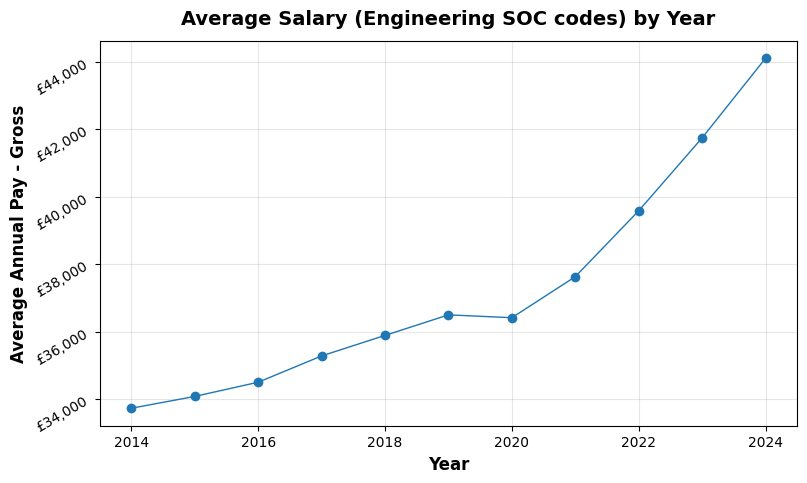

In [45]:
s_salary = plot_engineering_salary_trend(df_all)

In [46]:
# --- helpers ---
def _parse_year_from_period(val: str) -> int | None:
    if pd.isna(val):
        return None
    m = re.search(r'(\d{4})', str(val))
    return int(m.group(1)) if m else None

def _to_numeric_cols(df: pd.DataFrame, cols: list[str]) -> None:
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- main plotting function ---
def plot_vacancy_trends_by_sic(
    df_vac: pd.DataFrame,
    *,
    period_col: str = "SIC 2007 sections",
    sectors: list[str] | None = None,   # <- pick columns to plot; if None, plot all sector cols
    drop_cols: list[str] | None = None, # <- columns to exclude from sector plotting (e.g., "All vacancies1")
    title: str = "Vacancies by SIC sector (sum per year)",
    ylabel: str = "Vacancies (Thousands)",
    out_dir: str = "chart-18",
    filename: str = "chart18_vacancies_trends_by_sic",
    show: bool = True,
    rename_map: dict[str, str] | None = None # optional pretty legend names
):
    """
    Expects a WIDE table where the first column is a period label like 'Apr-Jun 2001'
    and other columns are numeric sector counts.

    - If `sectors` is provided, only those columns are plotted.
    - If `sectors` is None, all columns except [period_col, 'Year'] and any in `drop_cols` are plotted.
    """

    publication_rc()
    
    if period_col not in df_vac.columns:
        raise KeyError(f"'{period_col}' not found. Columns are: {list(df_vac.columns)}")

    df = df_vac.copy()

    # Derive Year
    df["Year"] = df[period_col].apply(_parse_year_from_period)
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)

    # Determine sector columns
    sector_cols = [c for c in df.columns if c not in (period_col, "Year")]
    if drop_cols:
        sector_cols = [c for c in sector_cols if c not in set(drop_cols)]

    # If user specified sectors, intersect with available
    if sectors is not None:
        # Keep only those that exist (silently skip typos)
        wanted = [c for c in sectors if c in df.columns]
        if not wanted:
            raise ValueError("None of the requested `sectors` were found in the DataFrame columns.")
        sector_cols = wanted

    if not sector_cols:
        raise ValueError("No sector columns to plot after applying `drop_cols`/`sectors`.")

    # Numeric conversion
    _to_numeric_cols(df, sector_cols)

    # Aggregate by Year
    yearly = df.groupby("Year", as_index=False)[sector_cols].mean().sort_values("Year")
    yearly = yearly[(yearly["Year"] >= 2014) & (yearly["Year"] <= 2025)]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in sector_cols:
        label = rename_map.get(col, col) if rename_map else col
        ax.plot(yearly["Year"], yearly[col], marker="o", label=str(label), markersize=4)

    ax.set_title(title, pad=12)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    fig.subplots_adjust(right=0.78)  # give space on the right
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    # ax.set_xlim(2014, 2025)
    ax.set_xticks(list(range(2014, 2026)))

    # Your save/show utility
    save_or_show(fig, out_dir=out_dir, filename=filename, show=show)

    return yearly, sector_cols


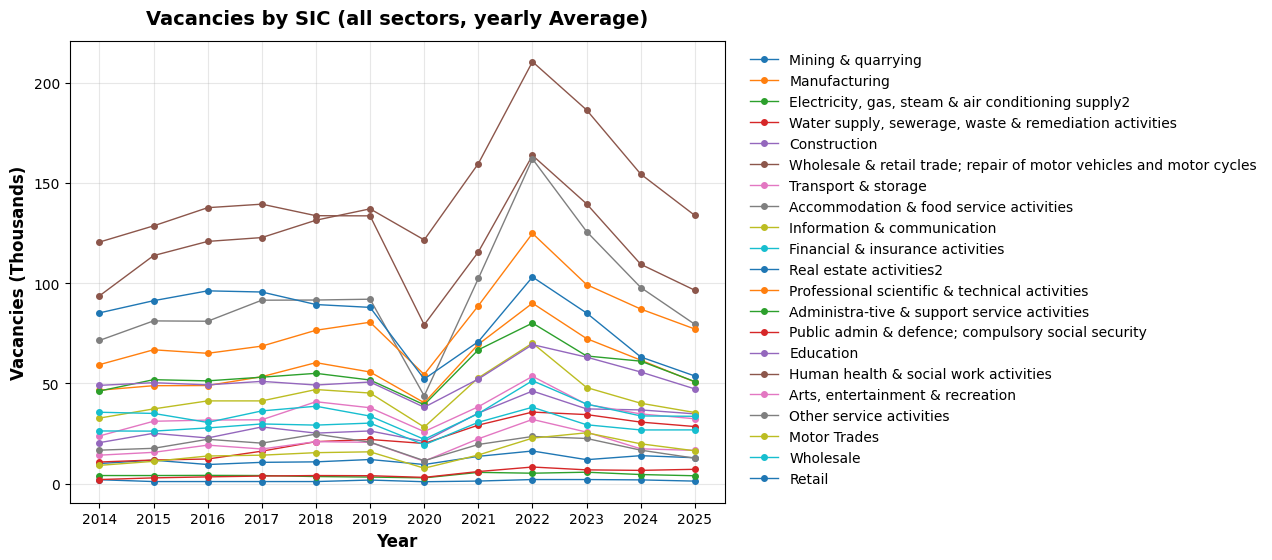

In [47]:
yearly_all, used_cols = plot_vacancy_trends_by_sic(
    df_vac,
    period_col="SIC 2007 sections",
    drop_cols=["All vacancies1", "Total services " ],   # exclude overall total if present
    title="Vacancies by SIC (all sectors, yearly Average)",
    filename="chart18_vacancies_all"
)


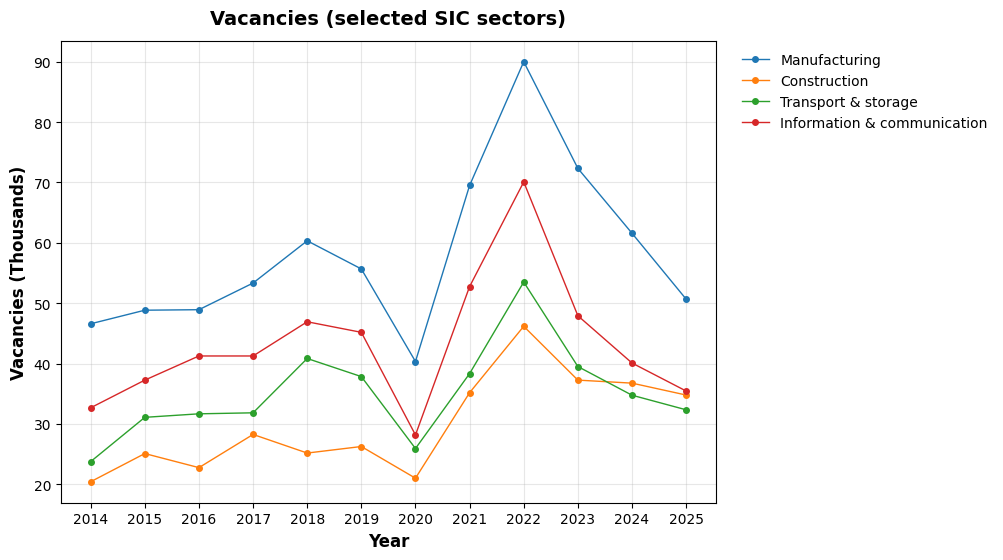

In [48]:
pick = [
    "Manufacturing",
    "Construction",
    "Transport & storage",
    "Information & communication"  # example if present in your file
]
yearly_sel, used_cols = plot_vacancy_trends_by_sic(
    df_vac,
    period_col="SIC 2007 sections",
    sectors=pick,
    drop_cols=["All vacancies1"],
    title="Vacancies (selected SIC sectors)",
    filename="chart18_vacancies_selected"
)
